# Trends in Reported Crime data

This notebook investigates whether there is evidence of consistent trends in the reported crime data.

## Set up BigQuery

In [1]:
import pandas as pd
from google.cloud import bigquery
client = bigquery.Client()
dataset_ref = client.dataset("reported_crime_data", project = "newsletter-analysis")
table_ref = dataset_ref.table("all_locations_and_violations")
table = client.get_table(table_ref)
table.schema

[SchemaField('REF_DATE', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('GEO', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('Violations', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('Statistics', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('VALUE', 'FLOAT', 'NULLABLE', None, (), None)]

Display the distinct levels of "Statistics" and "Violations" for later reference:

In [2]:
query = '''
           SELECT DISTINCT Statistics
           FROM `newsletter-analysis.reported_crime_data.all_locations_and_violations`
        '''
query_job = client.query(query)
query_job.to_dataframe()

,Statistics
0,Total cleared
1,Actual incidents
2,Cleared by charge
3,Cleared otherwise
4,Percent unfounded
5,Unfounded incidents
6,"Total, adult charged"
7,"Total, youth charged"
8,"Total, persons charged"
9,"Total, youth not charged"


In [3]:
query = '''
           SELECT DISTINCT Violations
           FROM `newsletter-analysis.reported_crime_data.all_locations_and_violations`
        '''
query_job = client.query(query)
query_job.to_dataframe()

,Violations
0,"Total, all violations [0]"
1,"Total, all Criminal Code violations (including..."
2,"Total, all Criminal Code violations (excluding..."
3,Total violent Criminal Code violations [100]
4,Homicide [110]
...,...
308,"Failure or refusal to comply with demand, acci..."
309,"Failure or refusal to comply with demand, acci..."
310,"Failure or refusal to comply with demand, acci..."
311,Parent or guardian procuring sexual activity: ...


Identify the most common types of incidents recorded in the data for Waterloo Region:

In [4]:
query = '''
           SELECT Violations, AVG(VALUE) as avg_value
           FROM `newsletter-analysis.reported_crime_data.all_locations_and_violations`
           WHERE GEO = 'Kitchener-Cambridge-Waterloo, Ontario [35541]' 
                and Statistics = 'Actual incidents'
           GROUP BY Violations
           ORDER BY avg_value DESC
        '''
query_job = client.query(query)
top_incidents = query_job.to_dataframe()
top_incidents.head(20)

,Violations,avg_value
0,"Total, all violations [0]",29522.958333
1,"Total, all Criminal Code violations (including...",28181.583333
2,"Total, all Criminal Code violations (excluding...",27225.416667
3,Total property crime violations [200],19139.333333
4,"Total theft under $5,000 (non-motor vehicle) [...",8312.666667
5,Total violent Criminal Code violations [100],5032.250000
6,"Theft $5,000 or under [2140]",3820.708333
7,"Theft $5,000 or under from a motor vehicle [2142]",3391.125000
8,Total mischief [250],3350.666667
9,Mischief [2170],3350.541667


## Total Violations in Waterloo Region

This section looks at trends in the rate of Total Violations in Waterloo Region.

In [5]:
query = '''SELECT REF_DATE, VALUE
            FROM `newsletter-analysis.reported_crime_data.all_locations_and_violations`
            WHERE GEO = 'Kitchener-Cambridge-Waterloo, Ontario [35541]' 
                and Violations = 'Total, all violations [0]' 
                and Statistics = 'Rate per 100,000 population'
        '''
query_job = client.query(query)
WR_rate_data = query_job.to_dataframe()
WR_rate_data.head()

,REF_DATE,VALUE
0,1998,7305.70
1,1999,6797.61
2,2000,6421.60
3,2001,6091.61
4,2002,6147.20


<AxesSubplot:xlabel='REF_DATE', ylabel='VALUE'>

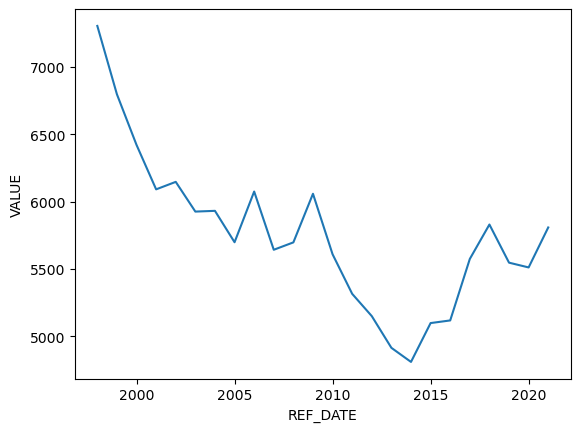

In [6]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.lineplot(data = WR_rate_data, x = 'REF_DATE', y = 'VALUE')

Extract data on percentage changes in rate for comparison.

In [7]:
query = '''SELECT REF_DATE, VALUE
            FROM `newsletter-analysis.reported_crime_data.all_locations_and_violations`
            WHERE GEO = 'Kitchener-Cambridge-Waterloo, Ontario [35541]' 
                and Violations = 'Total, all violations [0]' 
                and Statistics = 'Percentage change in rate'
        '''
query_job = client.query(query)
WR_change_data = query_job.to_dataframe()
WR_change_data.head()

,REF_DATE,VALUE
0,1999,-6.95
1,2000,-5.53
2,2001,-5.14
3,2002,0.91
4,2003,-3.59


In [8]:
mean_change = WR_change_data['VALUE'].mean()
mean_change

-0.8704347826086958

In [9]:
std_change = WR_change_data['VALUE'].std()
std_change

5.046221339019083

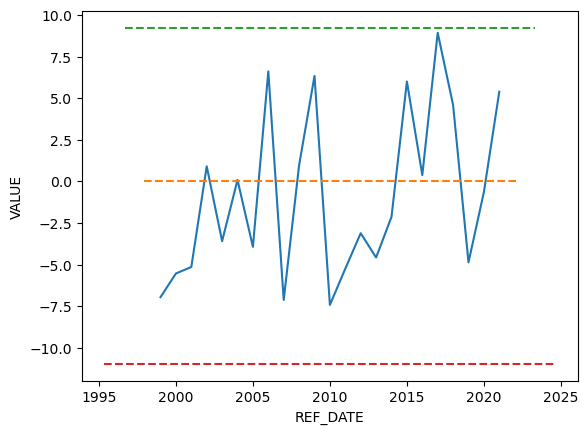

In [10]:
sns.lineplot(data = WR_change_data, x = 'REF_DATE', y = 'VALUE')
import matplotlib.pyplot as plt 
import numpy as np    

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
abline(slope = 0, intercept = 0)
abline(slope = 0, intercept = mean_change + 2 * std_change)
abline(slope = 0, intercept = mean_change - 2 * std_change)

# Impact of data cutoff point

This section contains some preliminary investigation into the impact that the selection of a cutoff point has on the results.

In [27]:
import statsmodels.api as sm
def regression_result(cutoff_point, data):
    recent_data = data.loc[data.REF_DATE >= cutoff_point]
    X = sm.add_constant(recent_data['REF_DATE'])
    Y = recent_data['VALUE']
    ols = sm.OLS(Y, X)
    ols_result = ols.fit()
    return {'slope' : ols_result.params['REF_DATE'],
            'lower_ci' : ols_result.conf_int().iloc[1,0],
            'upper_ci' : ols_result.conf_int().iloc[1,1]}
regression_result(1998, WR_rate_data)

{'slope': -56.94535652173855,
 'lower_ci': -82.73252238266984,
 'upper_ci': -31.158190660807268}

In [30]:
slope_by_cutoff_point = {year : regression_result(year, WR_rate_data) for year in range(1998, 2021)}
slope_by_cutoff_point

{1998: {'slope': -56.94535652173855,
  'lower_ci': -82.73252238266984,
  'upper_ci': -31.158190660807268},
 1999: {'slope': -46.303201581027565,
  'lower_ci': -70.83199148829664,
  'upper_ci': -21.77441167375849},
 2000: {'slope': -38.47945228684344,
  'lower_ci': -63.3766762997236,
  'upper_ci': -13.582228273963281},
 2001: {'slope': -33.018675324674774,
  'lower_ci': -59.528057083925304,
  'upper_ci': -6.509293565424247},
 2002: {'slope': -30.436240601503705,
  'lower_ci': -59.64951447698241,
  'upper_ci': -1.2229667260249997},
 2003: {'slope': -25.43845614035115,
  'lower_ci': -57.334872892382094,
  'upper_ci': 6.457960611679795},
 2004: {'slope': -22.409958720330337,
  'lower_ci': -58.00132215455809,
  'upper_ci': 13.181404713897415},
 2005: {'slope': -17.563308823529738,
  'lower_ci': -57.27487787712571,
  'upper_ci': 22.148260230066235},
 2006: {'slope': -16.04874999999656,
  'lower_ci': -61.30926378371873,
  'upper_ci': 29.21176378372561},
 2007: {'slope': -2.621571428571656,
  